# TASK #1: UNDERSTAND THE PROBLEM STATEMENT AND BUSINESS CASE


<table>
  <tr><td>
    <img src="https://drive.google.com/uc?id=15eGnAbma5Q_j9CZZKi46Gh3-EpgSWYOV"
         alt="Fashion MNIST sprite"  width="1000">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1. Classifying disease using Deep Learning
  </td></tr>
</table>


![alt text](https://drive.google.com/uc?id=19BuQ5m0xZWC7vQN4jX9lukmJ4aE0EkL8)

![alt text](https://drive.google.com/uc?id=10tbeSkGZ0xdHtqTGhYwHhb9PPURw0BfD)

# TASK #2: IMPORT LIBRARIES AND DATASET

In [1]:
# This is a custom dataset that contains covid-19 x-ray images, viral pneumonia x-ray images, bacterial pneumonia x-ray iamges and normal person x-ray images.
# Each class contains 133 images.
# Dataset Source:
# https://github.com/ieee8023/covid-chestxray-dataset
# https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia


import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [2]:
# You will need to mount your drive using the following commands:
# For more information regarding mounting, please check this out: https://stackoverflow.com/questions/46986398/import-data-into-google-colaboratory

# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# Specify training data directory
X_Ray_Directory = f'4. Operations Department{os.path.sep}Dataset'

In [4]:
# List the folders in the directory
X_Ray_Directory
os.listdir(X_Ray_Directory)



['0', '1', '3', '2']

In [5]:
# Use image generator to generate tensor images data and normalize them
# Use 20% of the data for cross-validation
image_generator = ImageDataGenerator(rescale = 1./255, validation_split=0.2)

In [6]:
# Generate batches of 40 images
# Total number of images is 133*4 = 532 images
# Training is 428 (80%) and validation is 104 (20%)
# Perform shuffling and image resizing

train_generator = image_generator.flow_from_directory(batch_size=40, directory=X_Ray_Directory, shuffle=True, target_size=(256,256), class_mode='categorical', subset='training')

Found 428 images belonging to 4 classes.


In [7]:
validation_generator = image_generator.flow_from_directory(batch_size=40, directory=X_Ray_Directory, shuffle=True, target_size=(256,256), class_mode='categorical', subset='validation')

Found 104 images belonging to 4 classes.


In [8]:
# Generate a batch of 40 images and labels
train_images, train_labels = next(train_generator)

In [9]:
train_images.shape

(40, 256, 256, 3)

In [10]:
train_labels.shape

(40, 4)

In [11]:
label_names = {0: 'Covid-19', 1: 'Normal', 2:'Viral Pneumonia', 3:'Bacterial Penumonia'}

In [12]:
# labels Translator


# TASK #3: VISUALIZE DATASET

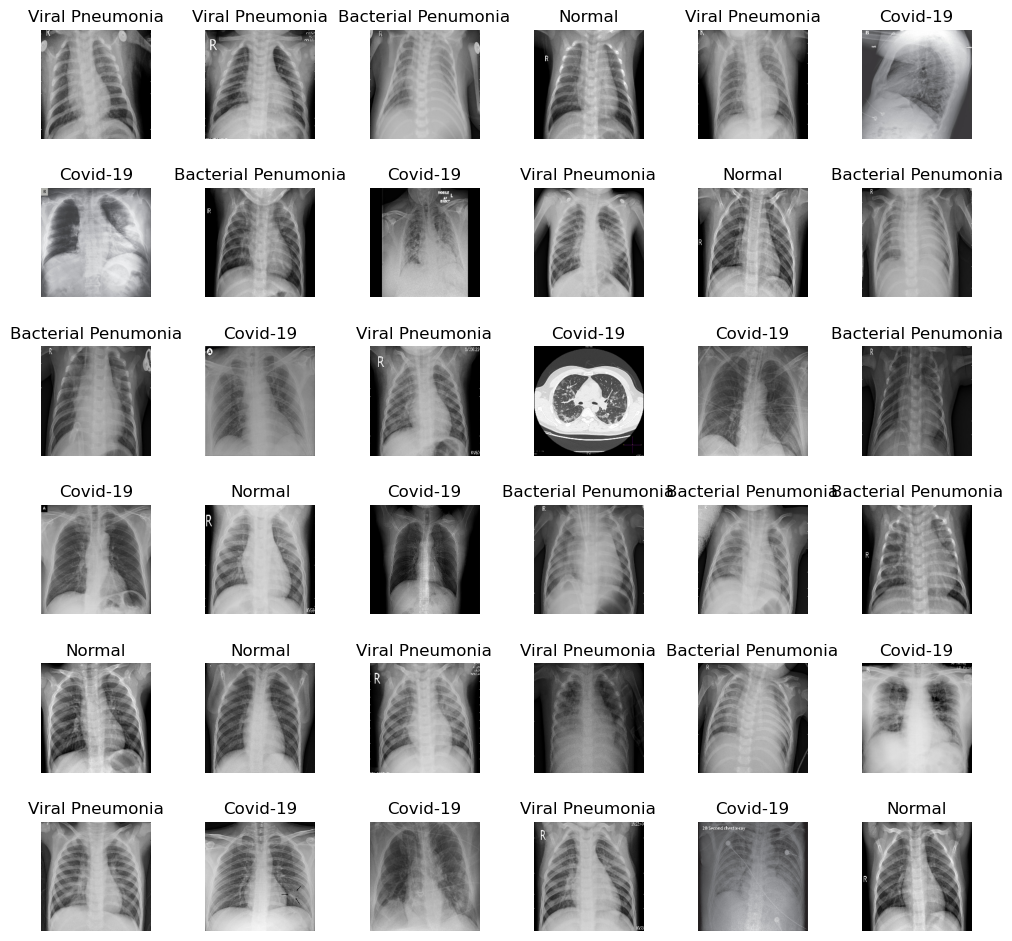

In [13]:
L = 6
W = 6


fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()




for i in np.arange(0, L * W):
    axes[i].imshow(train_images[i])
    label = np.argmax(train_labels[i])
    axes[i].set_title(label_names[label])
    axes[i].axis('off')

plt.subplots_adjust(wspace= 0.5)


# TASK #4: UNDERSTAND THE THEORY AND INTUITION BEHIND CONVOLUTIONAL NEURAL NETWORKS

![alt text](https://drive.google.com/uc?id=176TJGdJtNZmX4J5QyeI8W_YS5f1gg5VS)

![alt text](https://drive.google.com/uc?id=1340UvqbXc-sy6cIuVg7ZbOwcga2JxfkP)

![alt text](https://drive.google.com/uc?id=1hngDlUf9JnwUhPII-Ah7KTtcvoeTI9m8)

![alt text](https://drive.google.com/uc?id=1nt8iX7H2LEhaWgGCi_NIb05DMQEoJVfI)

# TASK #5: UNDERSTAND THE THEORY AND INTUITION BEHIND TRANSFER LEARNING

![alt text](https://drive.google.com/uc?id=1Wnti2DSmA2qMRsgkD7Z_MJkmed0bJZTN)

![alt text](https://drive.google.com/uc?id=1Chdq0gdnHGYDDb50pMMtcTOZMr0u37Iz)

![alt text](https://drive.google.com/uc?id=14niGb232X6l8OD1dMT4a_u3fjh_jKuMS)

![alt text](https://drive.google.com/uc?id=1dye4zWALCDu8a1a-58HfZk4On4nVuizV)

# TASK #6: IMPORT MODEL WITH PRETRAINED WEIGHTS

In [16]:
basemodel = ResNet50(weights= 'imagenet', include_top=False, input_tensor=Input(shape = (256,256, 3)))


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step


In [17]:
basemodel.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [18]:
# freezing layers in the model
for layer in basemodel.layers[:-10]:
    layers.trainable = False


# TASK #7: BUILD AND TRAIN DEEP LEARNING MODEL

In [20]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size= (4,4))(headmodel)
headmodel = Flatten(name = 'flatten')(headmodel)
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = 'relu')(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(4, activation='softmax')(headmodel)

In [21]:
model = Model(inputs = basemodel.input, outputs = headmodel)

In [26]:
# model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.RMSprop(lr = 1e-4, metrics = ['accuracy']))


model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate = 1e-4, decay = 1e-6), metrics= ["accuracy"])

/Users/zsomborveres-lakos/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [33]:
# using early stopping to exit training if validation loss is not decreasing after certain number of epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss

checkpointer = ModelCheckpoint(filepath="weights.hdf5.keras", verbose=1, save_best_only=True)



In [34]:
train_generator = image_generator.flow_from_directory(batch_size=4, directory= X_Ray_Directory, shuffle=True, target_size= (256, 256), class_mode='categorical', subset = 'training')



val_generator = image_generator.flow_from_directory(batch_size=4, directory= X_Ray_Directory, shuffle=True, target_size= (256, 256), class_mode='categorical', subset = 'validation')

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [37]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 4, epochs = 10, validation_data= val_generator, validation_steps= val_generator.n // 4, callbacks=[checkpointer, earlystopping])

Epoch 1/10


/Users/zsomborveres-lakos/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 838ms/step - accuracy: 0.5841 - loss: 1.0850
Epoch 1: val_loss improved from inf to 10.81864, saving model to weights.hdf5xd.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 111s 899ms/step - accuracy: 0.5851 - loss: 1.0831 - val_accuracy: 0.2500 - val_loss: 10.8186
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10


2024-10-13 17:38:12.647185: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/zsomborveres-lakos/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-10-13 17:38:12.687688: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/zsomborveres-lakos/anaconda3/lib/python3.11/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/Users/zsomborveres-lakos/anaconda3/lib/python3.

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 870ms/step - accuracy: 0.8434 - loss: 0.5069
Epoch 3: val_loss improved from 10.81864 to 9.53462, saving model to weights.hdf5xd.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 99s 921ms/step - accuracy: 0.8435 - loss: 0.5069 - val_accuracy: 0.2500 - val_loss: 9.5346
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10


2024-10-13 17:39:51.620893: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 848ms/step - accuracy: 0.8875 - loss: 0.2900
Epoch 5: val_loss did not improve from 9.53462
107/107 ━━━━━━━━━━━━━━━━━━━━ 96s 897ms/step - accuracy: 0.8875 - loss: 0.2902 - val_accuracy: 0.2500 - val_loss: 41.6557
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 799ms/step - accuracy: 0.9085 - loss: 0.3318
Epoch 7: val_loss did not improve from 9.53462
107/107 ━━━━━━━━━━━━━━━━━━━━ 91s 846ms/step - accuracy: 0.9085 - loss: 0.3315 - val_accuracy: 0.2500 - val_loss: 87.1005
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10


2024-10-13 17:42:58.559778: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 808ms/step - accuracy: 0.9486 - loss: 0.1336
Epoch 9: val_loss did not improve from 9.53462
107/107 ━━━━━━━━━━━━━━━━━━━━ 92s 855ms/step - accuracy: 0.9487 - loss: 0.1334 - val_accuracy: 0.2500 - val_loss: 110.4646
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00


# TASK #8: EVALUATE TRAINED DEEP LEARNING MODEL

In [38]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

Text(0.5, 0, 'Epochs')

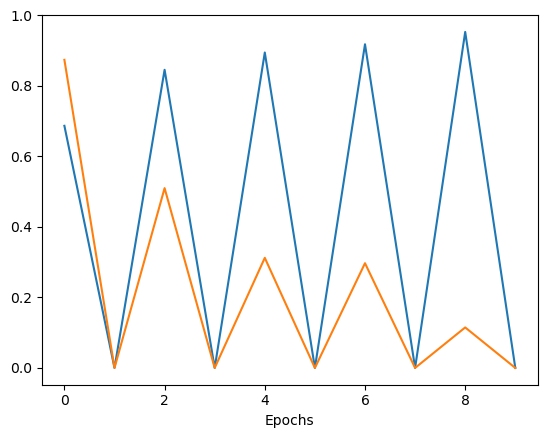

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.xlabel('Epochs')

Text(0, 0.5, 'Validation loss')

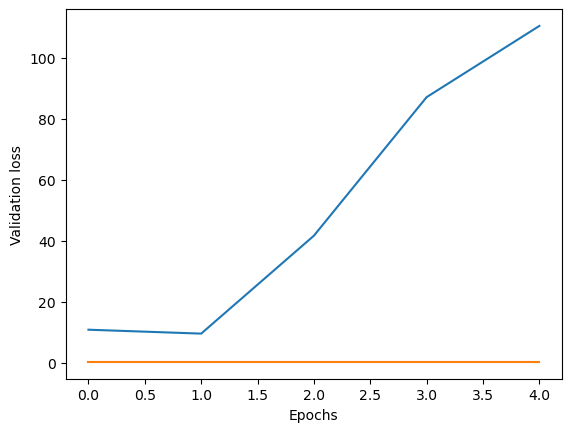

In [42]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Validation loss')

In [45]:
test_directory = f'4. Operations Department{os.path.sep}Test'

In [53]:
test_gen = ImageDataGenerator(rescale= 1./255)
tet_generator = test_gen.flow_from_directory(batch_size = 40, directory = test_directory, shuffle = True, target_size = (256,256), class_mode = 'categorical')
evaluate = model.evaluate(test_gen, steps = test_gen.n//4, verbose = 1)


print('Accuracy Test: {}'.format(evaluate[1]))
# AttributeError: 'ImageDataGenerator' object has no attribute 'n' (?)

Found 40 images belonging to 4 classes.


AttributeError: 'ImageDataGenerator' object has no attribute 'n'

# EXCELLENT JOB! YOU SHOULD BE PROUD OF YOUR NEWLY ACQUIRED SKILLS